In [1]:
import os
os.environ["DISABLE_MPI"]="true"
import numpy as np
import solenspipe
from pixell import enmap, curvedsky, lensing
from falafel import qe,utils
import pytempura

Read map and mask

In [2]:
map_filename = "/global/cscratch1/sd/jia_qu/maps/kcoadd_IQU_18no220.fits"
map_data=enmap.read_map(map_filename)

mask_filename = f"/global/cscratch1/sd/jia_qu/maps/downgrade/aggmask.fits"
mask = enmap.read_map(mask_filename) 

Set up various things 
- ell range 
- geometric things like pixelization 
- Just use TT for now

In [3]:
lmin=600
lmax=2000
shape,wcs = mask.shape[-2:],mask.wcs
nside = None
healpix = False
res_arcmin = np.rad2deg(enmap.pixshape(shape, wcs)[0])*60.
mlmax = int(4000 * (2.0/res_arcmin))
pmap = enmap.pixsizemap(shape,wcs)
px = qe.pixelization(shape=shape,wcs=wcs)
est1=est2="TT"

Need to initialize some theory stuff. What does grad=True do?

In [4]:
grad=True
ucls,tcls = utils.get_theory_dicts(grad=grad)

Get the normalizations

In [5]:
norm_stuff = solenspipe.get_tempura_norms(est1,est2,ucls,tcls,lmin,lmax,mlmax)
bh,ells,Als,R_src_tt,Nl_g,Nl_c,Nl_g_bh=norm_stuff

In [6]:
print(Als['TT'].shape)

(2, 8000)


Apply mask, and get $a_{lm}$s (a tuple with the $a_{lm}$s for T,E,B)

In [7]:
masked_map_data = map_data * mask
alms = curvedsky.map2alm(masked_map_data,lmax=mlmax)
#t_alm,e_alm,b_alm = solint.get_kmap(channel,seed,lmin,lmax,filtered=True)

Filter these

In [8]:
alms_filtered = utils.isotropic_filter(alms,tcls,lmin,lmax,ignore_te=True)

/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/utils.py:90: RuntimeWarning: divide by zero encountered in true_divide
  filt_T[2:] = 1./tcltt[2:]
/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/utils.py:91: RuntimeWarning: divide by zero encountered in true_divide
  filt_E[2:] = 1./tclee[2:]
/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/utils.py:92: RuntimeWarning: divide by zero encountered in true_divide
  filt_B[2:] = 1./tclbb[2:]


Ok, now we can do our reconstruction. We need to define our "qfunc", which is the function that actually does this. We use the `solenspipe.get_qfunc` function to set this. We provide the normalization Als, so should not need to apply that again to the resulting reconstructed alms.

In [9]:
qfunc = solenspipe.get_qfunc(px,ucls,mlmax,
                             est1,Al1=Als[est1],
                             est2=None,Al2=None,
                             R12=None)

We can do the reconstruction now by calling the qfunc with our alms

In [12]:
recon_phi_alms = qfunc(alms,alms)

In [13]:
recon_kappa_alms = lensing.phi_to_kappa(recon_phi_alms)

In [14]:
kappa_cl = curvedsky.alm2cl(recon_kappa_alms[0],recon_kappa_alms[0])
curl_cl = curvedsky.alm2cl(recon_kappa_alms[1],recon_kappa_alms[1])

Apply wfactor

In [15]:
w4 = solenspipe.wfactor(4, mask)
kappa_cl /= w4
curl_cl /= w4

Make a plot - it'll look weird because we've done no bias subtraction

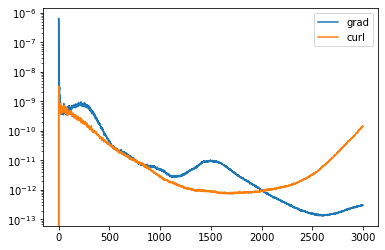

In [16]:
%matplotlib inline
import pylab
ells = np.arange(0,mlmax+1)
pylab.plot(ells[:3000],kappa_cl[:3000],label='grad')
pylab.plot(ells[:3000],curl_cl[:3000],label='curl')
pylab.yscale('log')
pylab.legend()

Yep looks weird 